In [1]:
import pandas as pd
import numpy as np
import re

from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from wordcloud import WordCloud

from code.viz import word_plot

sns.set()

from joblib import parallel_backend, Parallel, delayed
from multiprocessing import Pool
import multiprocessing

# increasing display to view large descriptions and reviewText
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, make_scorer
from wordcloud import WordCloud

from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTENC, SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

In [95]:
descript_genre = pd.read_csv('./data/nlp_descript_genre')
descript_genre.drop_duplicates(subset='description', inplace=True)
descript_genre.dropna(subset='description',inplace=True)
descript_genre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80157 entries, 0 to 80232
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   genre        80157 non-null  object
 1   description  80157 non-null  object
 2   title        80157 non-null  object
 3   starring     80157 non-null  object
 4   movie_id     80157 non-null  object
dtypes: object(5)
memory usage: 3.7+ MB


In [97]:
descript_df = descript_genre[descript_genre['genre'].isin(descript_genre['genre'].value_counts()[descript_genre['genre'].value_counts() >= 2000].index)]
descript_df.drop(columns=['title', 'starring', 'movie_id'],inplace=True)
descript_df['genre'] = descript_df['genre'].str.replace('.*Anime.*', 'Animation', regex=True)
descript_df['genre'] = descript_df['genre'].str.replace('.*Music.*', 'Musical & Performing Arts', regex=True)
descript_df = descript_df[descript_df['genre'] != 'Special Interests']
descript_df['genre'].value_counts()

genre
Documentary                  11664
Drama                         8878
Action & Adventure            7765
Musical & Performing Arts     7697
Comedy                        6735
Kids & Family                 5764
Animation                     5032
Sports                        3683
Science Fiction & Fantasy     3114
Horror                        2337
Name: count, dtype: int64

In [102]:
descript_df = descript_df[(descript_df['description'].str.len() >= 450) & (descript_df['description'].str.len() <= 600)]
descript_df.dropna(subset='description', inplace=True)
descript_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9507 entries, 49 to 80226
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   genre        9507 non-null   object
 1   description  9507 non-null   object
dtypes: object(2)
memory usage: 222.8+ KB


In [101]:
fiver = descript_df.copy()
fiver['reviews_len'] = fiver['description'].str.len()
avg_review_len = fiver['reviews_len'].median()
avg_review_len

488.0

In [103]:
descript_df['genre'].value_counts()

genre
Documentary                  1702
Drama                        1472
Action & Adventure           1270
Comedy                       1043
Musical & Performing Arts     977
Kids & Family                 858
Animation                     762
Sports                        591
Science Fiction & Fantasy     493
Horror                        339
Name: count, dtype: int64

In [104]:
sw = stopwords.words('english')

tokenizer = RegexpTokenizer('\w+')

In [105]:
def tokenize_sw(text):
    
    words = tokenizer.tokenize(text)

    words = [word for word in words if word not in sw]
    
    return ' '.join(words)

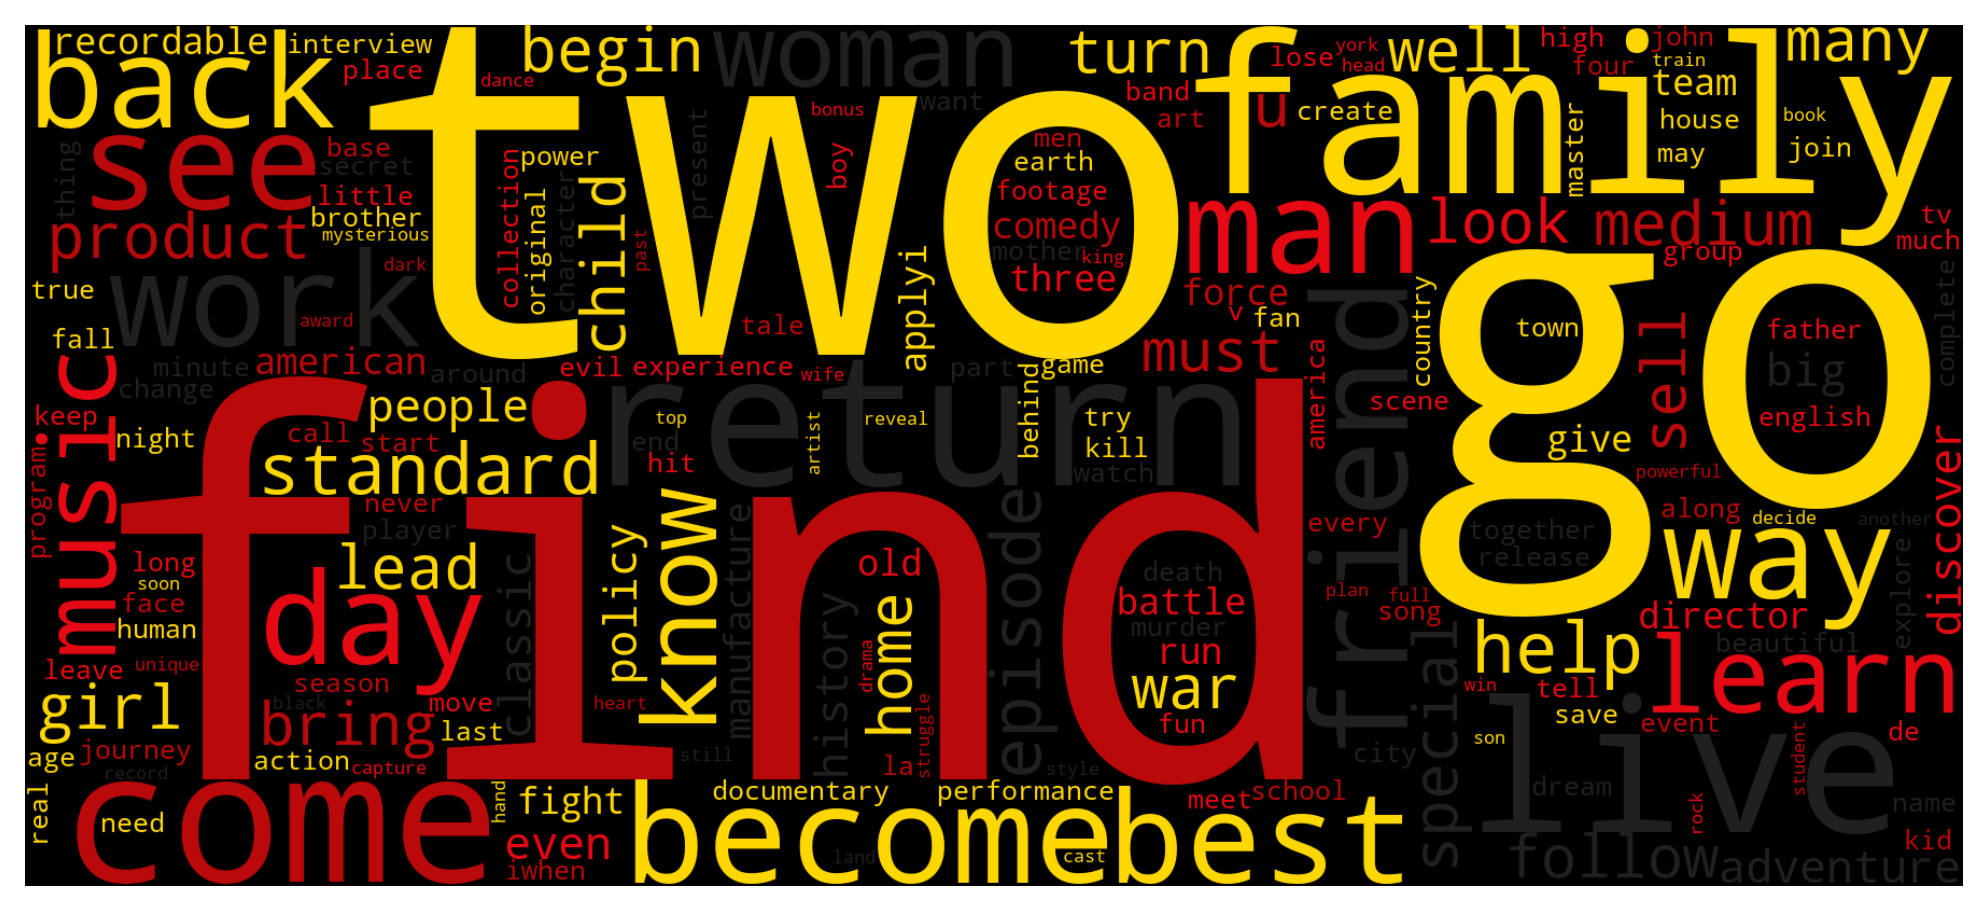

In [106]:
descript_df['description'] = descript_df['description'].apply(tokenize_sw)

flix_colors = [
    "#221f1f", "#b9090b",
    "#e50914", "#ffd700"
]
canvamap = ListedColormap(flix_colors)


wordcloud = WordCloud(
    collocations=False, width=1800, height=800,
    colormap=canvamap, background_color='black'
).generate(' '.join(descript_df['description']))

plt.figure(figsize=(10, 14), dpi=250)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

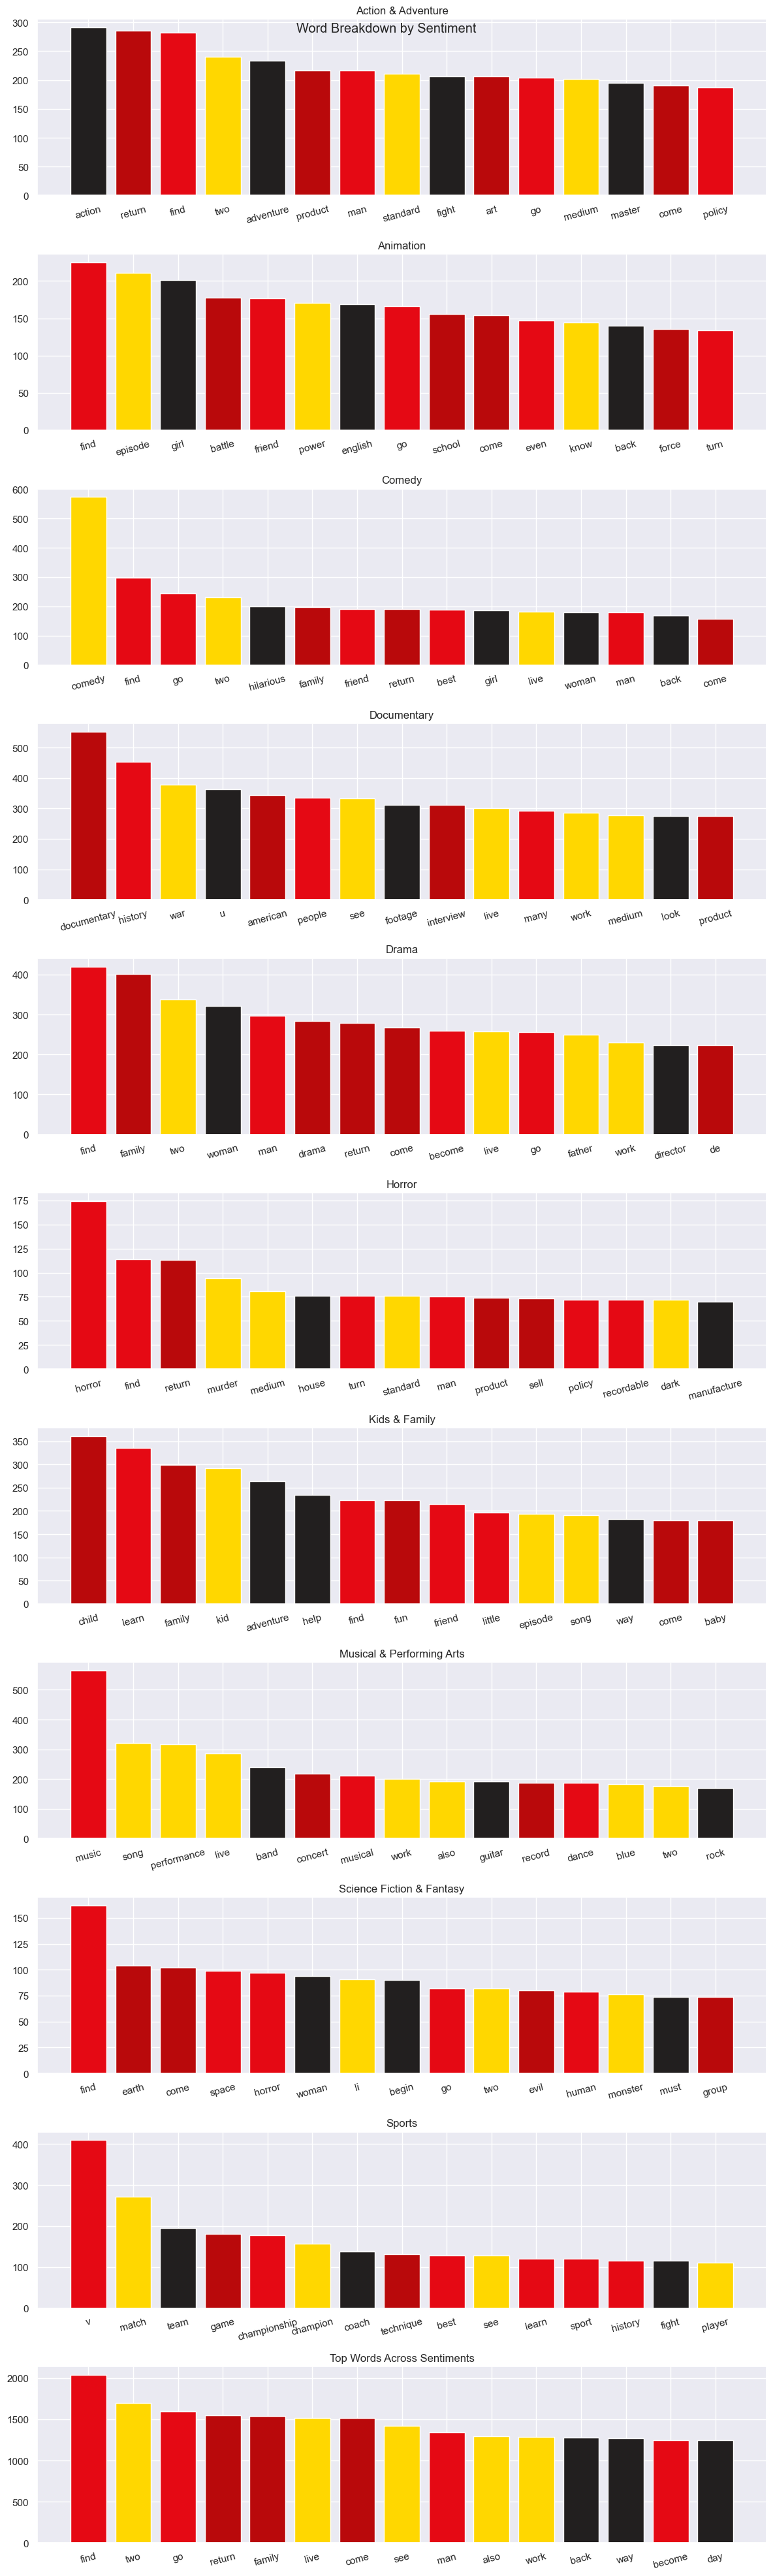

In [107]:
freq_words = word_plot(descript_df, 'genre', 'description',
    n_words=15, theme=flix_colors)

In [110]:
sw = ['find', 'also', 'work', 'go', 'see','return','two','live']

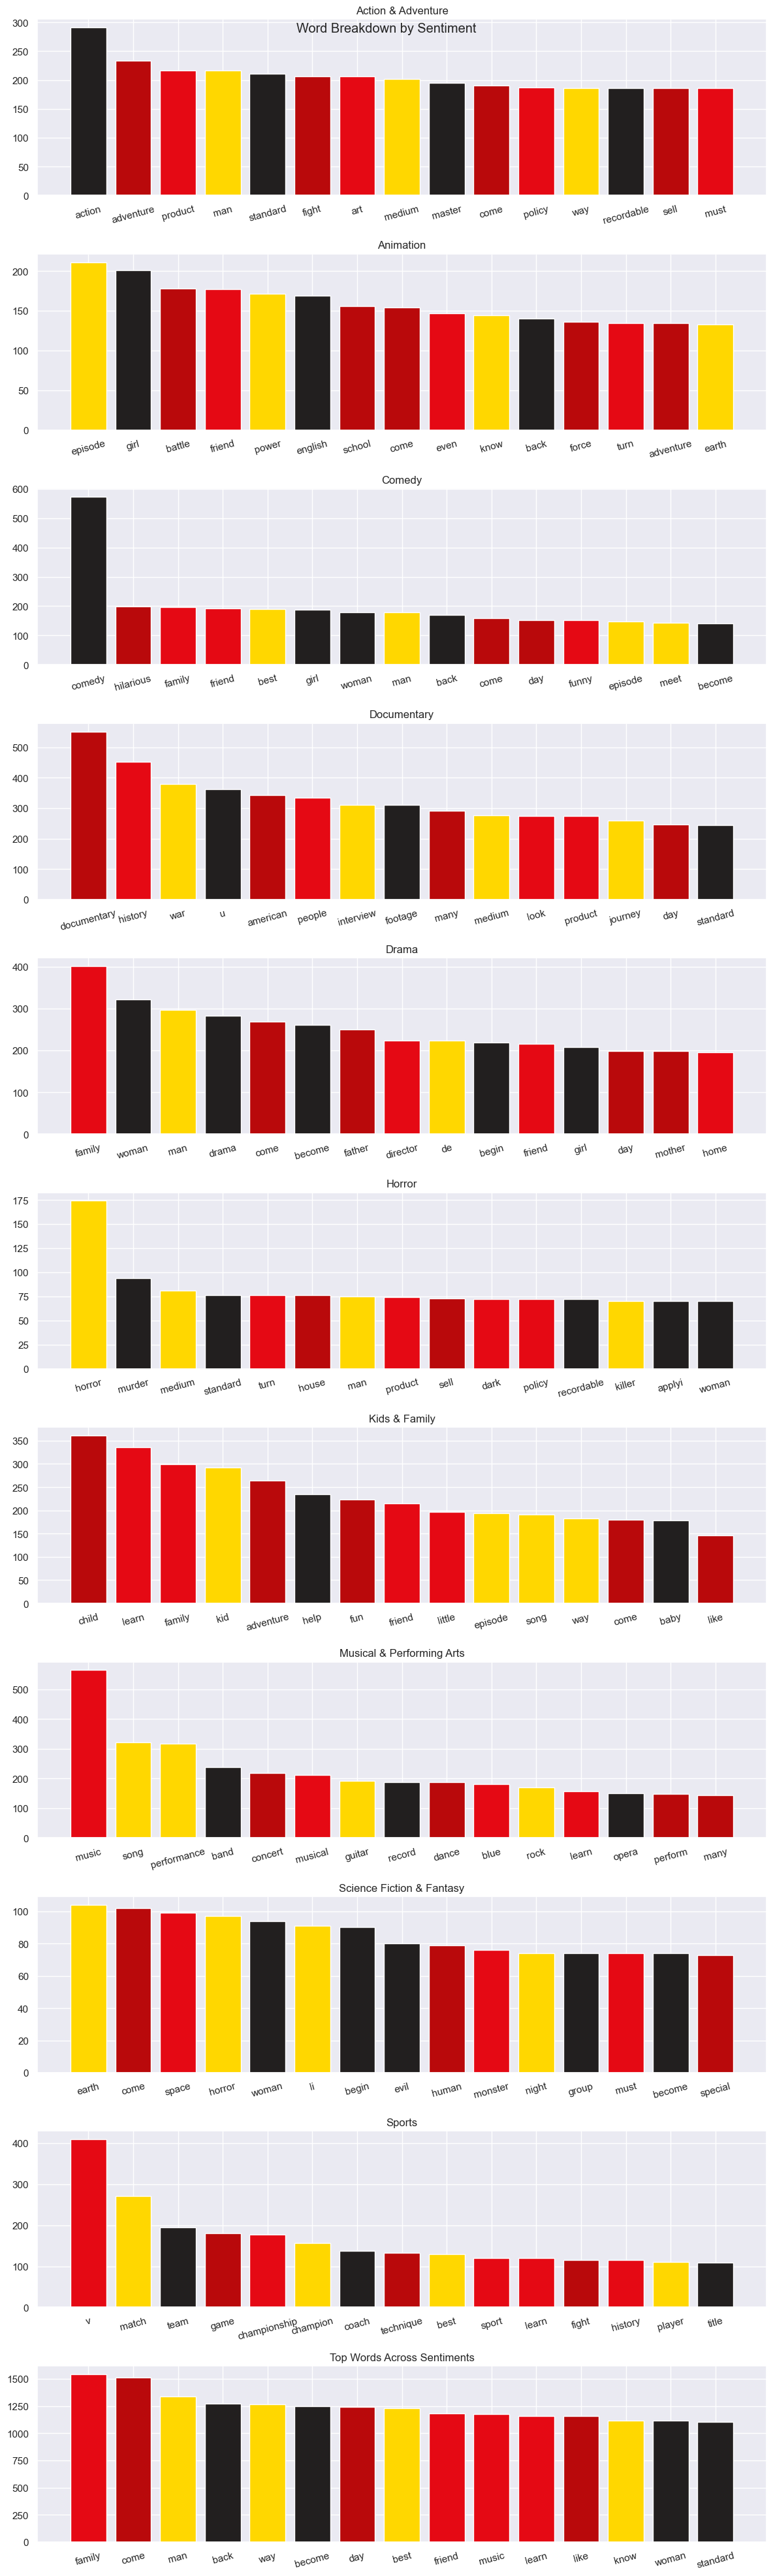

In [111]:
descript_df['description'] = descript_df['description'].apply(tokenize_sw)
freq_words = word_plot(descript_df, 'genre', 'description',
    n_words=15, theme=flix_colors)

In [116]:
X = descript_df['description']
y = descript_df['genre']

X_train, X_test, y_train, y_test = \
    train_test_split(X,y,
        test_size=0.25,
        stratify=y,random_state=42)

In [117]:
vectorizer = TfidfVectorizer(max_features=500)

vectorizer.fit(X_train)

TfidfVectorizer(max_features=500)

In [118]:
X_train_vectorized = vectorizer.transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [119]:
svec = imbPipeline(steps=[
    ('sm', SMOTE(random_state=42)),
    ('svec', SVC(random_state=42))
])

svec.fit(X_train_vectorized, y_train)

Pipeline(steps=[('sm', SMOTE(random_state=42)), ('svec', SVC(random_state=42))])

In [120]:
preds = svec.predict(X_train_vectorized)
f1_score(y_train, preds, average=None)

array([0.93156499, 0.97273527, 0.95522388, 0.94937695, 0.93422819,
       0.97455969, 0.95133438, 0.94843962, 0.9703504 , 0.97648376])

In [121]:
cross_val_score(svec, X_train_vectorized, y_train, scoring='f1_weighted').mean()

0.5296971005860229

In [122]:
preds = svec.predict(X_test_vectorized)
f1_score(y_test, preds, average=None)

array([0.43323442, 0.4984985 , 0.50099404, 0.6519337 , 0.54906542,
       0.37096774, 0.46039604, 0.65702479, 0.34615385, 0.57794677])